# EDIPI Workshop qgs tutorial - Part I: Computing the correlation properties of the system

This notebook is the second one of a tutorial given during the EDIPI workshop at RMI in January 2023.
In this tutorial, you will learn:

1. How to install the [qgs](https://github.com/Climdyn/qgs) framework for low-order climate and weather modeling
2. How to run the model
3. **How to compute the correlation properties of the underlying dynamical model**
4. How to compute the Largest Lyapunov Exponent (LLE) in the model
5. How to compute the full Lyapunov Exponent spectrum


Here we will be concerned with task 3 above: learning how to compute the autocorrelation of variables in the model.

We assume that you have already been through the [Introduction notebook](https://github.com/jodemaey/EDIPI-qgs-tutorial-on-predictability/blob/main/EDIPI%20workshop%20qgs%20tutorial%20-%20Introduction.ipynb), qgs and the tutorial being installed.

## Setup of the model

We use again the simple 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane with a simple orography (a montain and a valley), as in the Introduction notebook. But now, we are going to ...

First, we need to load the model, and integrate it to find an initial condition on the attractor, as in the Introduction notebook:

### Modules import

First, load some modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Importing the model's modules

In [2]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

and diagnostics

In [3]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

### Defining the model

First, we define some general parameters

In [4]:
# Time increment parameter
dt = 0.1
# Saving the model state every 5 steps
write_steps = 5
# transient time
transient_time = 10000.
# integration time
integration_time = 10000.


Now we create the model parameters object:

In [5]:
model_parameters = QgParams()

We set up some parameters:

In [6]:
# here we define the latitude to be 50 degrees and a predefined amplitude of the meridional temperature gradient
model_parameters.set_params({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd':0.045})

and indicate that we want an atmospheric channel for the atmosphere, with Fourier modes up to wavenumber 2 in each spatial direction:

In [7]:
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)

We also set some topography

In [8]:
model_parameters.ground_params.set_orography(0.2, 1)

and indicate the amplitude of the meridional temperature gradient which forces the model:

In [9]:
model_parameters.atemperature_params.set_thetas(0.1, 0)

and we are done configuring the model.

Finally, we create the tendencies $\boldsymbol{f}$ that will allow us to integrate the model equations:

In [10]:
%%time
f, Df = create_tendencies(model_parameters)

CPU times: user 6.39 s, sys: 765 ms, total: 7.15 s
Wall time: 6.35 s


### Time integration

We now integrate our model with the qgs built-in integrator:

In [11]:
integrator = RungeKuttaIntegrator()

We tell this integrator to use our defined model

In [12]:
integrator.set_func(f)

We can now start from a small random initial condition and integrate over a transient time to obtain an initial condition on the attractors

In [13]:
%%time
ic = np.random.rand(model_parameters.ndim)*0.1

integrator.integrate(0., transient_time, dt, ic=ic, write_steps=0)  # write_steps=0 will only give us the last step
time, ic = integrator.get_trajectories()

CPU times: user 980 µs, sys: 3.87 ms, total: 4.85 ms
Wall time: 2.44 s


and then we can integrate the model starting from this initial condition in order to obtain a trajectory on the attractor:

In [14]:
%%time
integrator.integrate(0., 1000., dt, ic=ic, write_steps=write_steps)
time, trajectory = integrator.get_trajectories()

CPU times: user 2.19 ms, sys: 184 µs, total: 2.37 ms
Wall time: 2.04 s


Let's have a look at the output. First let's print the shape of trajectory

In [15]:
print(trajectory.shape)

(20, 2001)


The first dimension contains the different variables (20). The second dimension is time, and it contains the values of the variables along the integration, including the initial condition. Its length is therefore (integration_time/dt)/write_steps+1. In order to plot the time series of one variable, say for index 1, we have then to plot trajectory[1,:].

What about time? The array time is in adimensional units. In order to plot a time series agains time expressed in dimensional units we have to multiply the time array by model_parameters.dimensional_time. We can then plot our time series against time expressed in days.

Text(0, 0.5, 'var1')

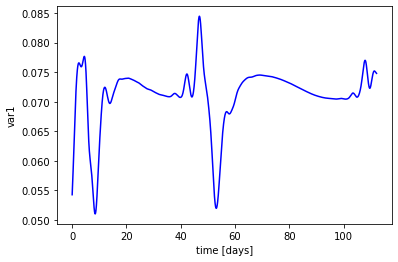

In [16]:
plt.figure()
plt.plot(time*model_parameters.dimensional_time,trajectory[0,:],'b')
plt.xlabel('time [days]')
plt.ylabel('var1')

Now we can proceed to analyse the predictability properties of the system.

## Some theory before the exercises:

Before working on the Lyapunov spectrum in the next parts of this tutorial, let's have a look at the autocorrelation function of our variable. The autocorrelation function is a useful statistical quantity in time series analysis that determines the properties of memory loss of a variable. 

The autocorrelation function of a stationary time series $x(t)$ with variance $\sigma^2$ and mean $\mu=0$ is

$$ R(t) = \frac{\mathbb{E}\left[x(s+t)x(s)\right]}{\sigma^2}$$

where $s$ is an arbitrary time instant. Alternatively, the autocorrelation function can be computed as a time integral

$$ R(t)= \lim_{T\rightarrow +\infty} \,\frac{1}{\sigma^2} \,\frac{1}{T} \,\int_0^T x(s+t)x(s)ds $$

exploiting the equivalence of time and ensemble averages for a stationary process.

The autocorrelation function determines the properties of memory loss of a process. Often one looks for an approximate behaviour 

$$ R(t) \approx e^{-t/\tau_0} $$

at least for the first part of the function, in order to single out a characteritic time scale. An important quantity that characterizes the memory properties of the process is the integral autocorrelation time $\tau_c$

$$ \tau_c=\lim_{T\rightarrow +\infty}\int_0^T R(t)dt $$

For a process with a perfect exponential autocorrelation function the integral autocorrelation time coincides with the e-folding time scale, i.e. the time taken by the function to decrease by a factor $e$. For a process with a more complicated autocorrelation function, it takes into account the contribution of possibly different decay rates in the tail. For some processes $\tau_c$ may even be infinite (in the sense that the limit in the definition does not converge). In this case we say that the process has long term memory (in climate long term memory has been found for example in data related to rivers discharge). The first e-folding time scale and the integral autocorrelation time in general give a first idea in terms of orders of magnitude of the characteristic time scales of predictability of the dynamics. 

In order to compute the autocorrelation function we can use the correlate function of [SciPy](https://scipy.org/). [`scipy.signal.correlate`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html#scipy.signal.correlate) computes the cross correlation of two vectors. Using it to compute the correlation of a time series with itself and dividing by the variance of the time series we have a simple estimate of the autocorrelation function.

Note: because of the way the [`scipy.signal.correlate`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html#scipy.signal.correlate) function works, we have to divide its output by the length of the original vector to get the expectation in the formula for $R(t)$, and take the second half of the output (that will be twice the length of the original input vector).


## Exercises:

Compute a long trajectory of the system to estimate the autocorrelation

In [17]:
%%time
integration_time = 100000.
integrator.integrate(0., integration_time, dt, ic=ic, write_steps=write_steps)
time, trajectory = integrator.get_trajectories()

CPU times: user 18.8 ms, sys: 63.8 ms, total: 82.6 ms
Wall time: 6.23 s


Compute the autocorrelation of a given variable of the model (for example the first one)

In [18]:
from scipy.signal import correlate

In [19]:
%%time
variable = 0
x = trajectory[variable] - np.mean(trajectory[variable])
sigma = np.sqrt(np.var(x))
autocorrelation = (correlate(x, x, mode='full')/ sigma**2) / len(x)


CPU times: user 15.7 ms, sys: 741 µs, total: 16.5 ms
Wall time: 15.8 ms


Plot it as a function of the time and then integrate it to get the integral autocorrelation time $\tau_c$

7.840805169602376


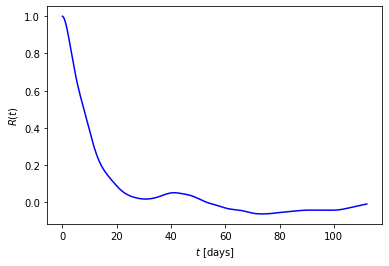

In [20]:
autocorrelation_plot=autocorrelation[int(x.size):int(x.size)+1000]
time_plot=np.linspace(0,len(autocorrelation_plot), len(autocorrelation_plot))*model_parameters.dimensional_time

plt.figure()
plt.plot(time_plot,autocorrelation_plot,'b')
plt.xlabel('$t$ [days]')
plt.ylabel('$R(t)$')


autocorrelation_time=np.sum(autocorrelation_plot)*(time_plot[1]-time_plot[0])
print(autocorrelation_time)

You can repeat this experiment with other variables. After that, you can also repeat this experiment but with different model parameters providing you a more chaotic atmosphere.

The End.